In [ ]:
import os
import pandas as pd
import numpy as np
import itertools

#viz 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing,metrics 
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report

In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#Read files
train = pd.read_csv(open('/gdrive/My Drive/data/train.csv'))
test = pd.read_csv(open('/gdrive/My Drive/data/test.csv'))

In [ ]:
train['id'] = train['\tid']
train.drop(columns=['\tid'],axis=0,inplace=True)

In [ ]:
train.head(2)

,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status,id
0,Others,VA,27-Apr-10,34,4,New,0,Rural,N,"$35,000.00","$35,000.00",1,4050975007
1,Manufacturing,CA,05-Nov-09,107,1,New,0,Rural,N,"$15,000.00","$13,500.00",1,3735095001


In [ ]:
train.isna().sum().sort_values(ascending=False)

industry          1
id                0
default_status    0
insured_amount    0
loan_amount       0
other_loans       0
location          0
business_type     0
business_new      0
employee_count    0
term              0
request_date      0
state             0
dtype: int64

Remove the industry null values

In [ ]:
train = train[~(train.industry.isna())]

##Data Transformation

In [ ]:
# Change the other_loan to int 
train.other_loans = train.other_loans.apply(lambda x: 1 if x =='Y' else 0)
test.other_loans = test.other_loans.apply(lambda x: 1 if x =='Y' else 0)

#Change the business new to int 
train.business_new = train.business_new.apply(lambda x: 1 if x =='New' else 0)
test.business_new = test.business_new.apply(lambda x: 1 if x =='New' else 0)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(train['industry'])
train['industry_label'] = le.transform(train.industry)
test['industry_label'] = le.transform(test.industry)

In [ ]:
# preprocess the loan_amount and insured amount 
# 1. To remove $ sign and comma. 
# 2. To convert the type to float. 
 train['loan_amount'] = train['loan_amount'].apply(lambda x: ''.join( x.strip('$').split(','))).astype(float)
 train['insured_amount'] = train['insured_amount'].apply(lambda x: ''.join( x.strip('$').split(','))).astype(float)
 
 test['loan_amount'] = test['loan_amount'].apply(lambda x: ''.join( x.strip('$').split(','))).astype(float)
 test['insured_amount'] = test['insured_amount'].apply(lambda x: ''.join( x.strip('$').split(','))).astype(float)
 

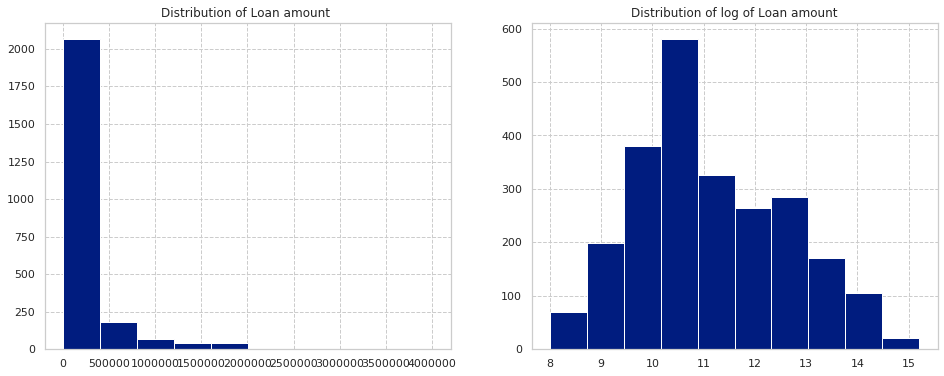

In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['loan_amount']);
plt.title('Distribution of Loan amount ');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['loan_amount']));
plt.title('Distribution of log of Loan amount');


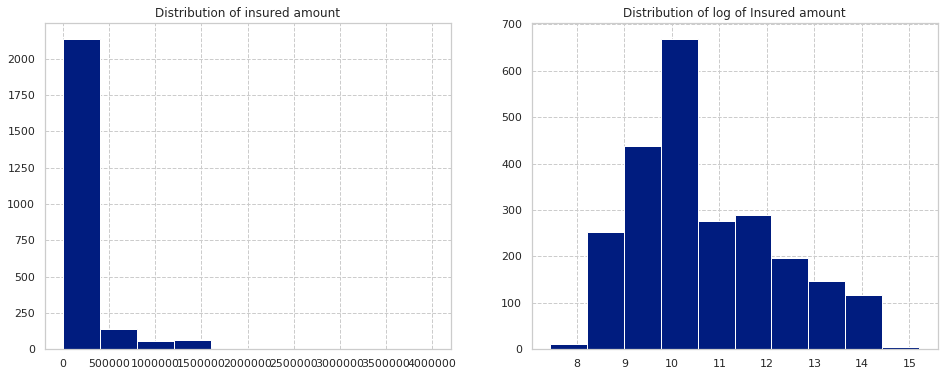

In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['insured_amount']);
plt.title('Distribution of insured amount');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['insured_amount']));
plt.title('Distribution of log of Insured amount');

As we can see loan amount and insured distribution has a high skewness! It is better to use np.log1p of loan amount.

In [ ]:
train['log_loan_amount']= np.log1p(train['loan_amount'])
train['log_insured_amount']= np.log1p(train['insured_amount'])

test['log_loan_amount']= np.log1p(test['loan_amount'])
test['log_insured_amount']= np.log1p(test['insured_amount'])

##Target Value

In [ ]:
# Check the Target Value 'Default_status' class percent 
#print(train.default_status.value_counts())
print('Percent of the class for loan defaulters \n' )
print((train.default_status.value_counts()*100)/len(train))

Percent of the class for loan defaulters 

0    67.805081
1    32.194919
Name: default_status, dtype: float64


To improve the imbalance of the class 1 we will set default_status for test data to 1 and then concat the both train and test.

In [ ]:
test['default_status'] = 1

In [ ]:
data = pd.concat([train,test]).reset_index(drop=True)

In [ ]:
print('Percent of the class for loan defaulters  \n' )
print((data.default_status.value_counts()*100)/len(data))

Percent of the class for loan defaulters  

0    54.230513
1    45.769487
Name: default_status, dtype: float64


The class improves from 32% to 45%. The distribution the class looks fine.

In [ ]:
data.isna().sum().sort_values(ascending=False)

term                  0
state                 0
request_date          0
other_loans           0
log_loan_amount       0
log_insured_amount    0
location              0
loan_amount           0
insured_amount        0
industry_label        0
industry              0
id                    0
employee_count        0
default_status        0
business_type         0
business_new          0
dtype: int64

## Data Analysis

In [ ]:
# Data detailed description
data.describe().T

,count,mean,std,min,25%,50%,75%,max
business_new,3002.0,6.988674e-01,4.588266e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
business_type,3002.0,5.263158e-02,2.233341e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
default_status,3002.0,4.576949e-01,4.982901e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
employee_count,3002.0,9.066955e+00,1.988809e+01,0.000000e+00,1.000000e+00,3.000000e+00,9.000000e+00,5.000000e+02
id,3002.0,3.960661e+09,1.777084e+08,3.672915e+09,3.804533e+09,3.954740e+09,4.119068e+09,4.280675e+09
industry_label,3002.0,8.655563e+00,4.912152e+00,0.000000e+00,3.000000e+00,1.000000e+01,1.400000e+01,1.500000e+01
insured_amount,3002.0,1.534362e+05,3.039748e+05,1.000000e+03,1.275000e+04,3.500000e+04,1.261875e+05,4.000000e+06
loan_amount,3002.0,2.013635e+05,3.539164e+05,2.000000e+03,2.500000e+04,5.001200e+04,2.169975e+05,4.000000e+06
log_insured_amount,3002.0,1.070794e+01,1.513045e+00,6.908755e+00,9.453365e+00,1.046313e+01,1.174553e+01,1.520181e+01
log_loan_amount,3002.0,1.115796e+01,1.446683e+00,7.601402e+00,1.012667e+01,1.082004e+01,1.228765e+01,1.520181e+01


In [ ]:
# Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 16 columns):
business_new          3002 non-null int64
business_type         3002 non-null int64
default_status        3002 non-null int64
employee_count        3002 non-null int64
id                    3002 non-null int64
industry              3002 non-null object
industry_label        3002 non-null int64
insured_amount        3002 non-null float64
loan_amount           3002 non-null float64
location              3002 non-null object
log_insured_amount    3002 non-null float64
log_loan_amount       3002 non-null float64
other_loans           3002 non-null int64
request_date          3002 non-null object
state                 3002 non-null object
term                  3002 non-null int64
dtypes: float64(4), int64(8), object(4)
memory usage: 375.4+ KB


In [ ]:
#Industry vs default_status
print((data.industry.value_counts()*100)/len(train))

Trading           26.322366
Consulting        14.202416
Construction      14.077468
Manufacturing     12.952936
Hotel             12.869638
Healthcare        11.162016
Others             8.788005
Administration     6.413994
Transportation     5.997501
Agriculture        2.957101
Real Estate        2.207414
Engineering        1.874219
Finance            1.707622
Entertainment      1.624323
Education          1.416077
Energy             0.458142
Name: industry, dtype: float64


In [ ]:
# New Business percentage vs default_status
print((data.business_new.value_counts()*100)/len(data))

1    69.886742
0    30.113258
Name: business_new, dtype: float64


In [ ]:
data['request_day'],data['request_month'],data['request_year'] = data['request_date'].str.split('-', 2).str

In [ ]:
months_order = ["Jan", "Feb", "Mar", "Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
data['request_month'] = pd.Categorical(data['request_month'],categories=months_order, ordered=True)

In [ ]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(data))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

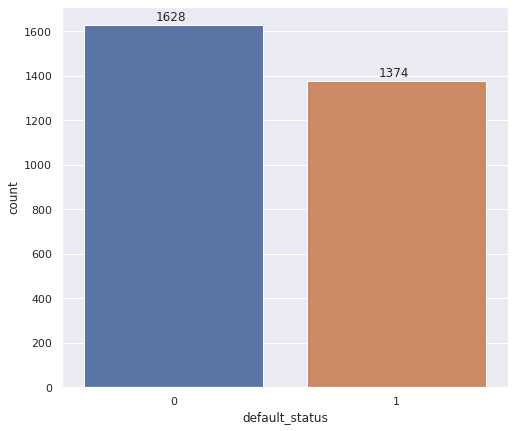

In [ ]:
univariate(df=data,col='default_status',vartype=1)

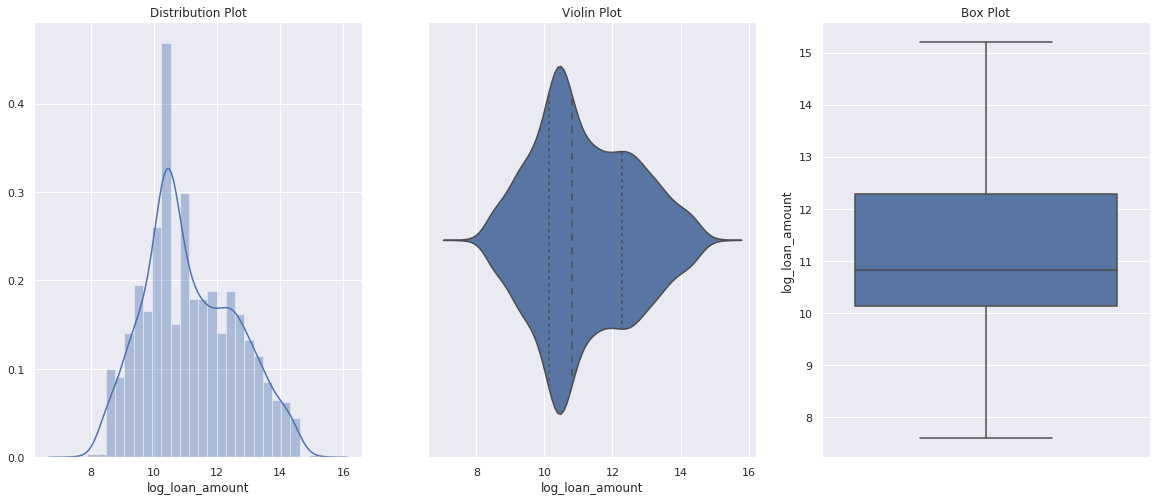

In [ ]:
univariate(df=data,col='log_loan_amount',vartype=0)

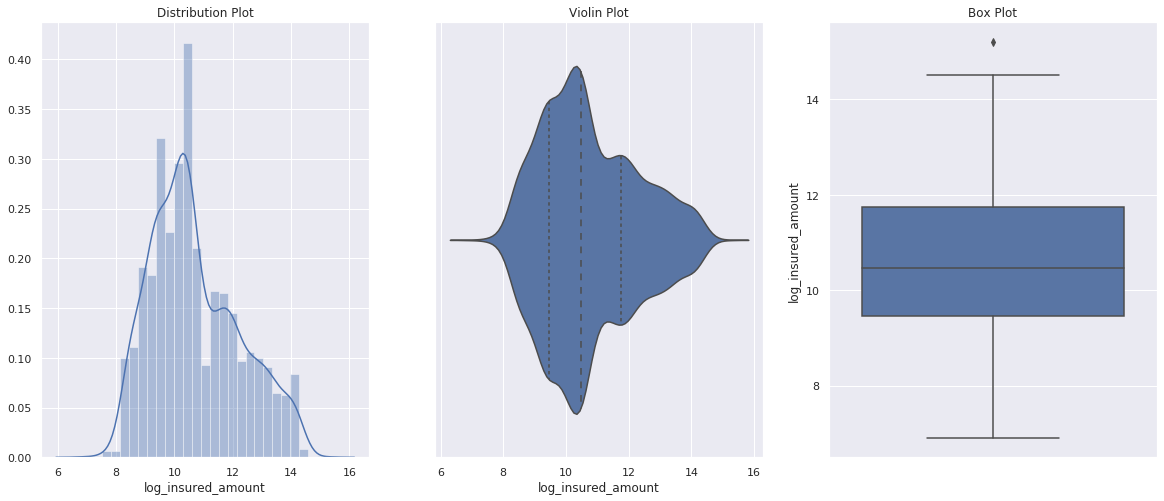

In [ ]:
univariate(df=data,col='log_insured_amount',vartype=0)

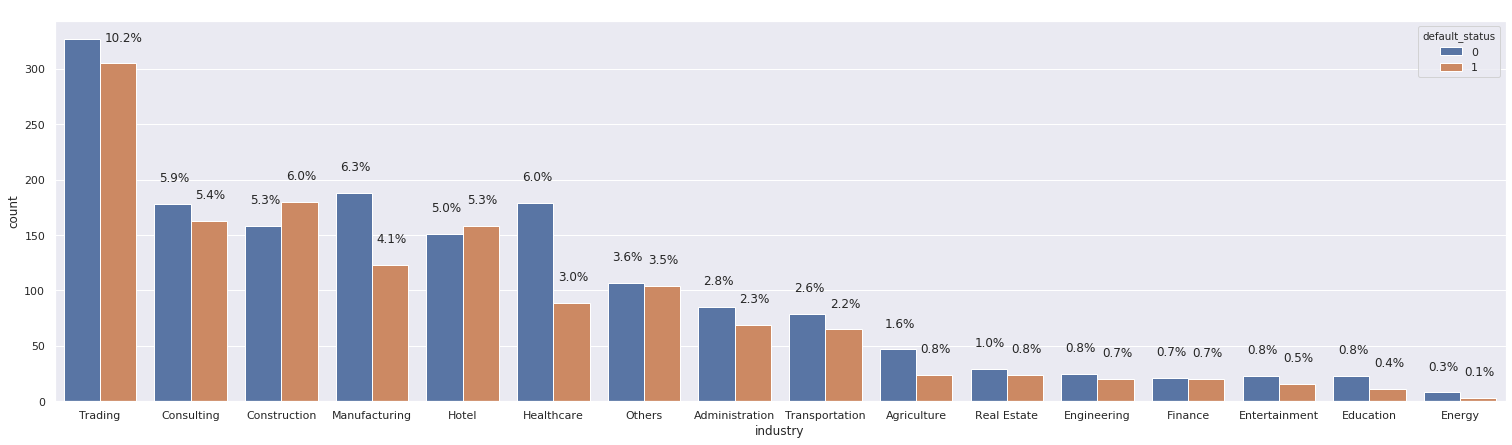

In [ ]:
univariate(df=data,col='industry',vartype=1,hue='default_status')

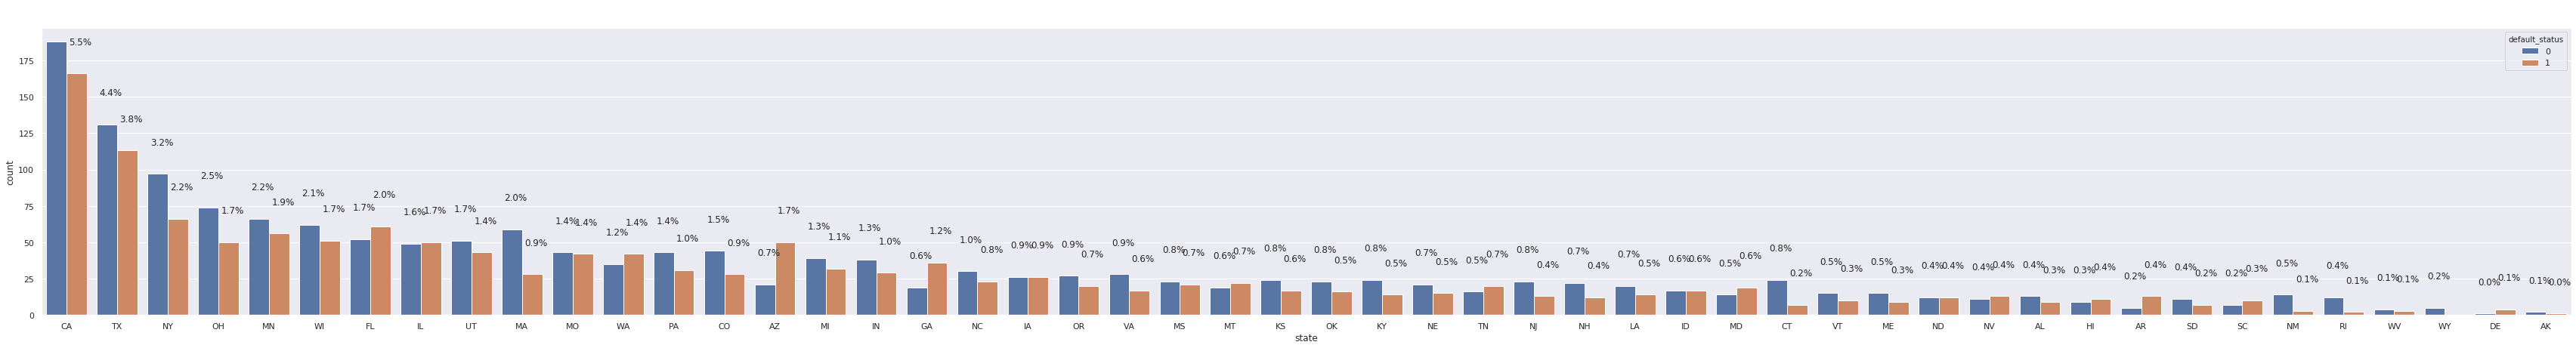

In [ ]:
univariate(df=data,col='state',vartype=1,hue='default_status')

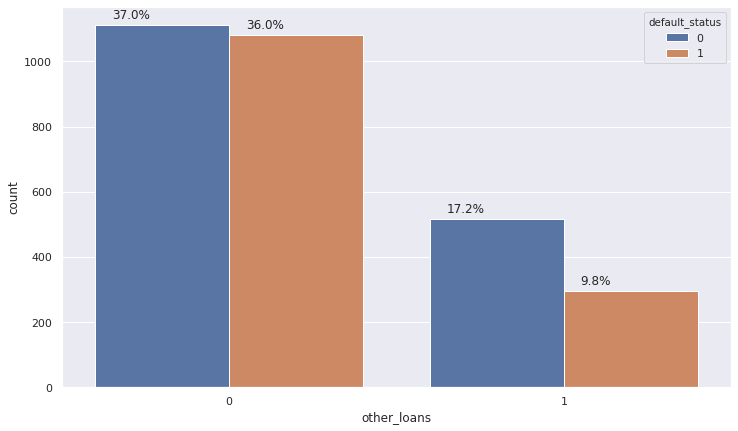

In [ ]:
univariate(df=data,col='other_loans',vartype=1,hue='default_status')

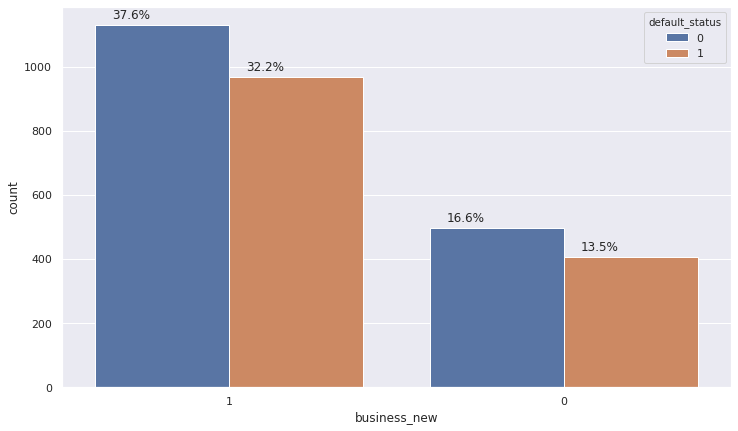

In [ ]:
univariate(df=data,col='business_new',vartype=1,hue='default_status')

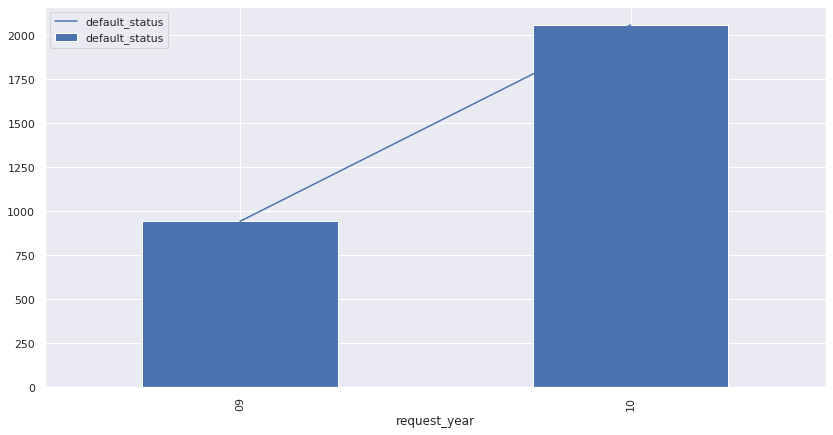

In [ ]:
year_wise =data.groupby(by= [data.request_year])[['default_status']].count()
year_wise.rename(columns={"loan_status": "count"},inplace=True)
ax =year_wise.plot(figsize=(14,7))
year_wise.plot(kind='bar',figsize=(14,7),ax = ax)
plt.show()

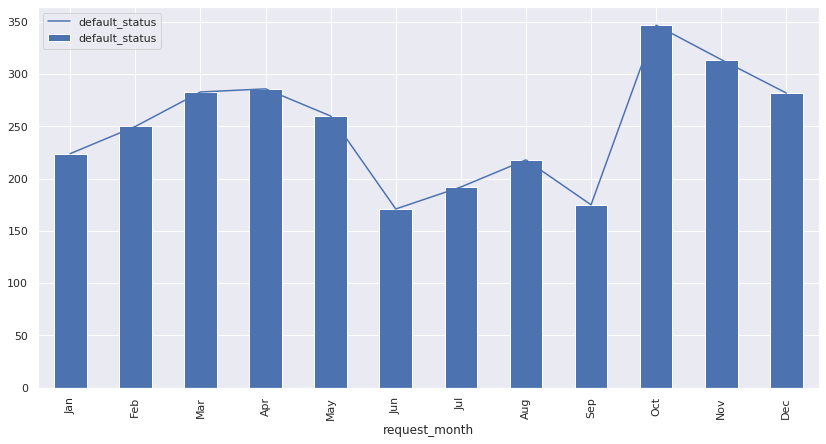

In [ ]:
month_wise =data.groupby(by= [data.request_month])[['default_status']].count()
month_wise.rename(columns={"loan_status": "count"},inplace=True)
ax = month_wise.plot(figsize=(14,7))
month_wise.plot(kind='bar',figsize=(14,7),ax = ax)
plt.show()

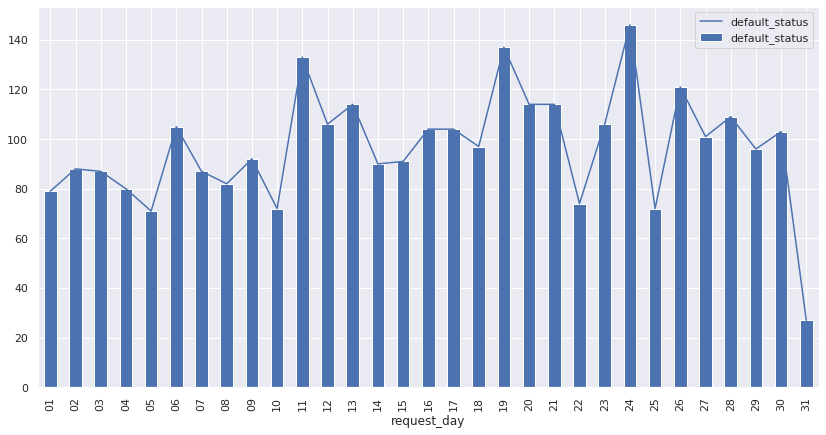

In [ ]:
day_wise =data.groupby(by= [data.request_day])[['default_status']].count()
day_wise.rename(columns={"loan_status": "count"},inplace=True)
ax = day_wise.plot(figsize=(14,7))
day_wise.plot(kind='bar',figsize=(14,7),ax = ax)
plt.show()

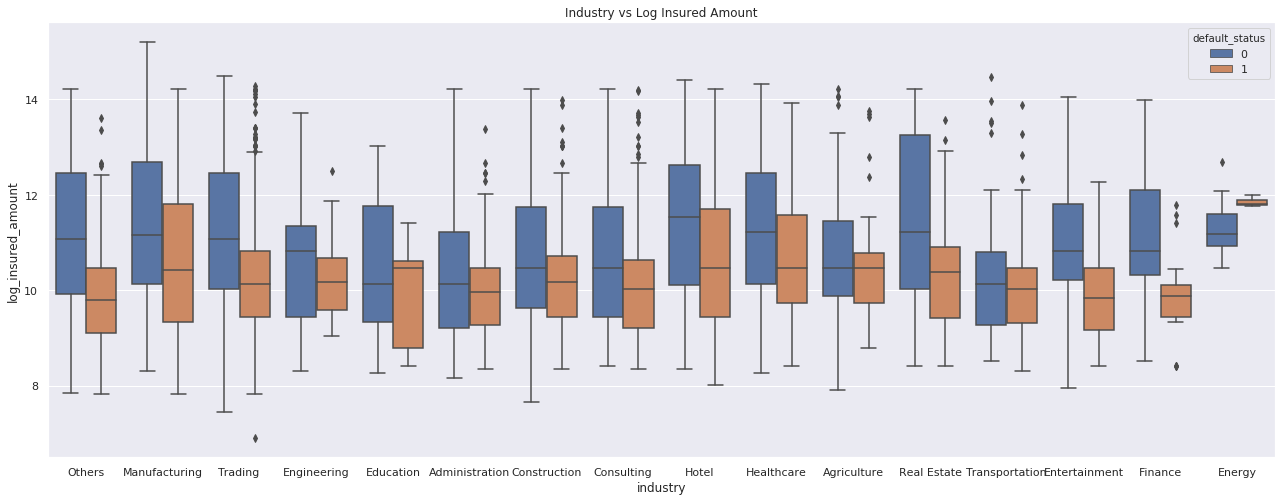

In [ ]:
plt.figure(figsize=(22,8))
sns.boxplot(data = data, x='industry', y='log_insured_amount', hue ='default_status')
plt.title('Industry vs Log Insured Amount')
plt.show()


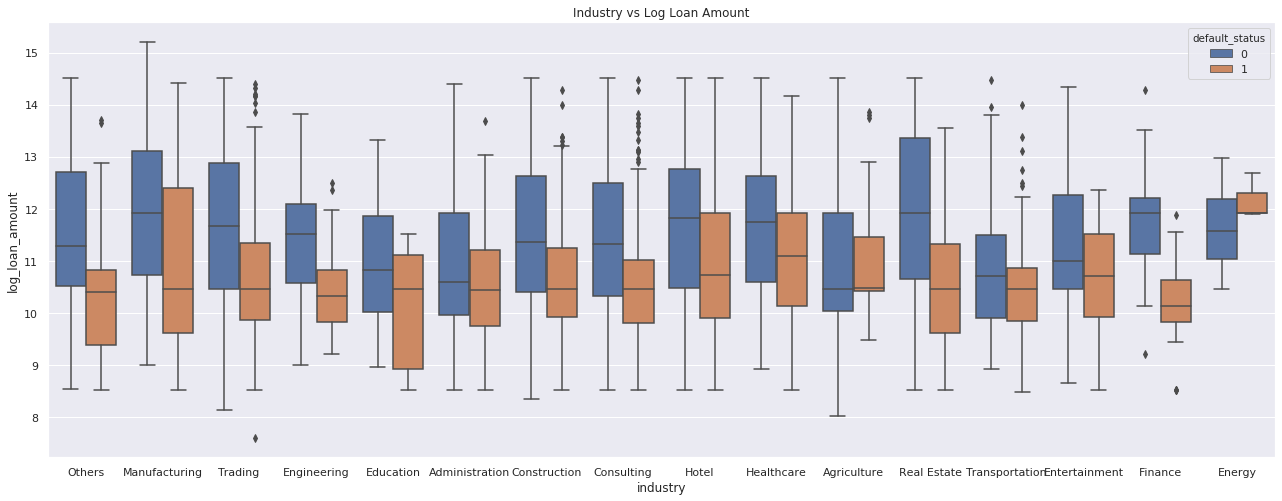

In [ ]:
plt.figure(figsize=(22,8))
sns.boxplot(data = data, x='industry', y='log_loan_amount', hue ='default_status')
plt.title('Industry vs Log Loan Amount')
plt.show()


In [ ]:
columns = ['industry_label','business_type','other_loans','term','employee_count', 'log_loan_amount',
            'log_insured_amount','default_status']
data_clean = data[columns]

In [ ]:
data_clean.corr()

,industry_label,business_type,other_loans,term,employee_count,log_loan_amount,log_insured_amount,default_status
industry_label,1.000000,0.060573,-0.084961,0.068374,0.007495,0.065699,0.090906,-0.004049
business_type,0.060573,1.000000,-0.089506,0.057791,0.012410,0.059327,0.086562,-0.033883
other_loans,-0.084961,-0.089506,1.000000,-0.245765,0.001010,0.024510,-0.220789,-0.115587
term,0.068374,0.057791,-0.245765,1.000000,0.079347,0.441047,0.508034,-0.172816
employee_count,0.007495,0.012410,0.001010,0.079347,1.000000,0.274039,0.270692,-0.124613
log_loan_amount,0.065699,0.059327,0.024510,0.441047,0.274039,1.000000,0.941120,-0.292654
log_insured_amount,0.090906,0.086562,-0.220789,0.508034,0.270692,0.941120,1.000000,-0.230024
default_status,-0.004049,-0.033883,-0.115587,-0.172816,-0.124613,-0.292654,-0.230024,1.000000


##Learning Curve

> This learning curve clearly shows that our models are not learning anything after ~2800 samples. So we randomly sampled our dataset and used only 2800 samples of our dataset.
> Note: In the plot, only ~2500 samples are shown because it is a plot for training set.


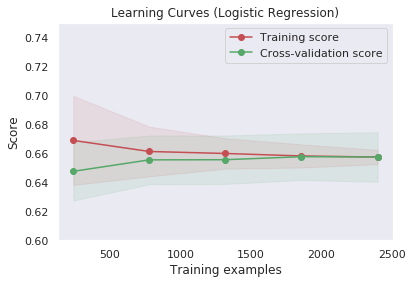

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.60, 0.75), cv=cv, n_jobs=4)
plt.show()

##ROC Curve plot function

This is a callable ROC curve plot function. We have used this function to plot ROC Curve for all the models. We have used Seaborn package.

In [ ]:
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

##Confusion Matrix Viz function

This is a callable Confusion Matrix Visualization function. We have used this function to visualize True positives, True Negatives, False Positives and False Negatives for all the models.

In [ ]:
#function prints and plots the confusion matrix.
def plot_confusion_matrix(model, normalize=False):      
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [ ]:
X_train.head()

,industry_label,business_type,other_loans,term,employee_count,log_loan_amount,log_insured_amount
700,0,1,0,94,14,11.074436,10.969077
226,2,0,0,83,3,8.517393,8.412055
1268,10,0,1,72,7,10.819798,10.126671
1010,2,0,0,25,2,10.463132,10.463132
2136,14,0,0,31,10,10.463132,10.357775


##Feature Selection using RFE (Recursive Feature Elimination)

In [ ]:
# create the RFE model and select 3 attributes
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 5)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True  True False  True  True  True]
[3 1 1 2 1 1 1]


In [ ]:
#PCA (Principal Component Analysis)
pca = PCA(n_components=5, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [9.04091128e-01 8.95624129e-02 5.58598230e-03 6.78610202e-04
 6.08832717e-05]


In [ ]:
features = ['business_type','other_loans','term','employee_count', 'log_loan_amount',
            'log_insured_amount','default_status']
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(2401, 6)
(3002, 7)


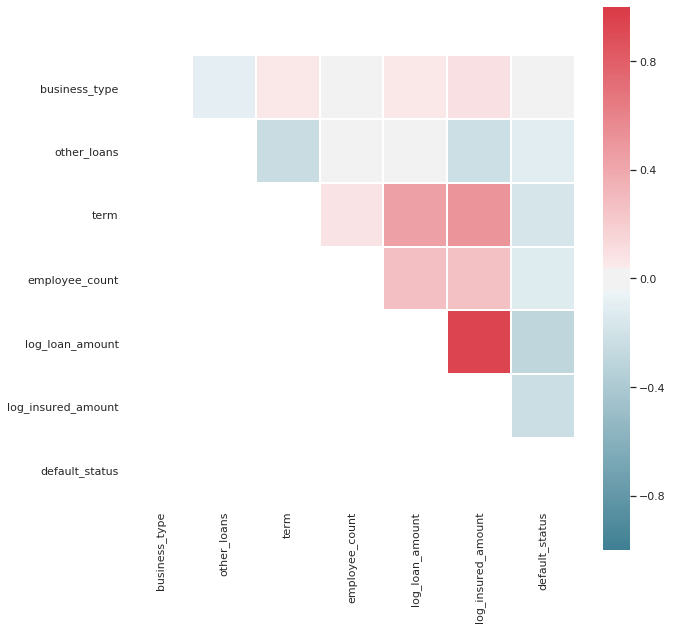

In [ ]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

#Models

##Random Forest with randomized Search

Random forest when implemented with randomized search we got the best accuracies and minimum false negatives(predicting borowwer will not default eventhough he will. This might impact on the credibility of the company). We used the randomized search to find the best hyper paramters for the model.

In [ ]:
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
mean_scores = rand.cv_results_['mean_test_score']
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [ ]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.7470881863560732


##Feature Importance

Text(0, 0.5, 'Normalized Gini Importance')

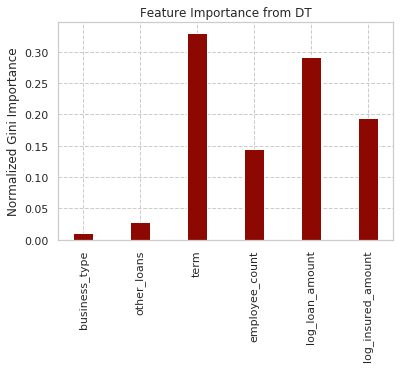

In [ ]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

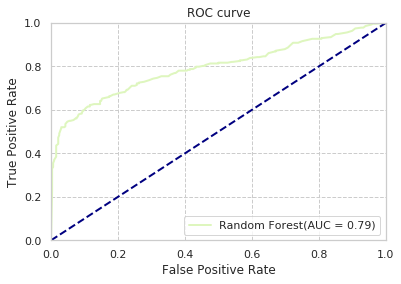

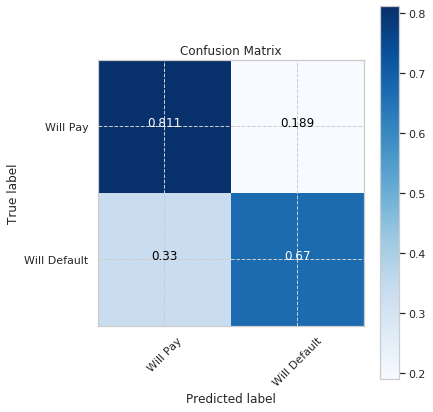

In [ ]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

##Logistic Regression with Grid Search

Logistic Regression when implemented with grid search we got the best accuracies and minimum false negatives. We used the randomized search to find the best hyper paramters for the model.

In [ ]:
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = grid.cv_results_['mean_test_score']
    return mean_scores,grid.best_score_,grid.best_estimator_
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

Best accuracy is 0.6578527131782945
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Logistic regression accuracy is  0.6589018302828619


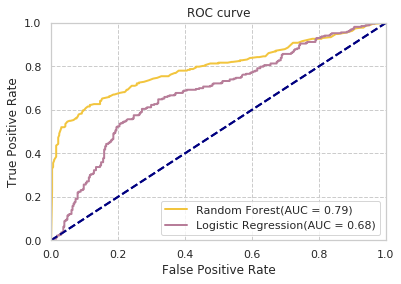

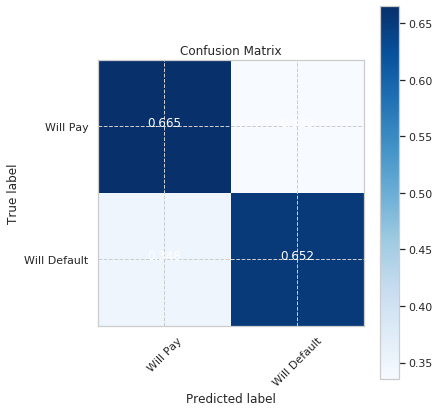

In [ ]:
clf_LR = linear_model.LogisticRegression(C=Best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

##Support Vector Machines(SVM) with Grid Search CV

SVM (Support Vector Machines) when implemented with grid search, we got the best accuracies and minimum false negatives. We used the Grid search to find the best hyper paramters for the model.Later we used this value to find the predictions and plot the ROC curve.

In [ ]:
clf_svm = svm.SVC()
powers = range(0,5)
cs = [10**i for i in powers]
param_grid = dict(C=cs)
grid = GridSearchCV(clf_svm, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
grid_mean_scores = grid.cv_results_['mean_test_score'] # create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'C': 10000}
---------------
SVC(C=10000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


SVM accuracy is  0.6655574043261231


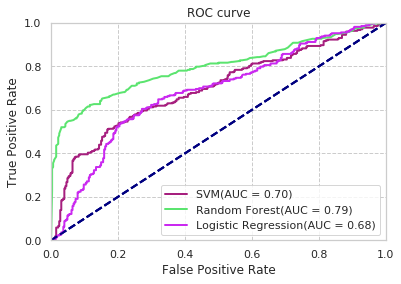

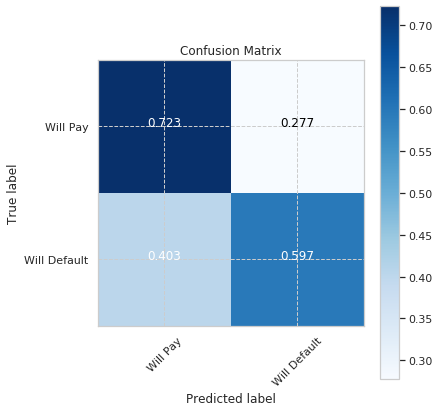

In [ ]:
clf_svm = svm.SVC(kernel = "rbf", C=grid.best_estimator_.C)
clf_svm.fit(X_train.iloc[:,:],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,:])
predictproba_svm = clf_svm.decision_function(X_test.iloc[:,:])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

##K Nearest Neighbors(KNN) with Grid Search CV

KNN (K Nearest Neighbors) when implemented with grid search, we got the best accuracies and minimum false negatives. We used the Grid search to find the best hyper paramters for the model

In [ ]:
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
grid_mean_scores = grid.cv_results_['mean_test_score']# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 35}
---------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')


 35
KNN accuracy is  0.7287853577371048


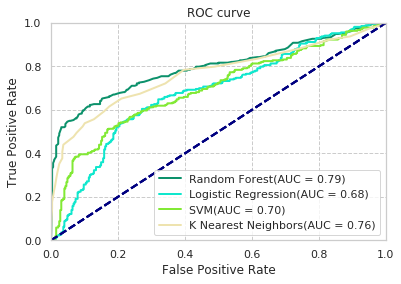

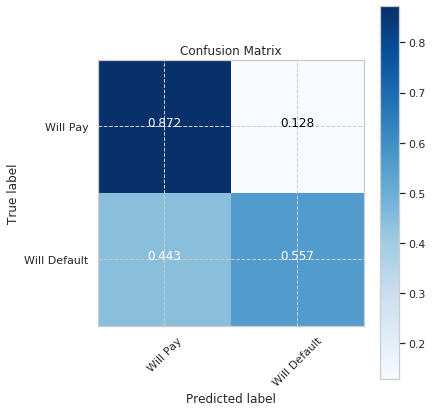

In [ ]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

##Precision,recall,F1score for all models

In [ ]:
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))

RF               precision    recall  f1-score   support

           0       0.75      0.81      0.78       328
           1       0.75      0.67      0.71       273

    accuracy                           0.75       601
   macro avg       0.75      0.74      0.74       601
weighted avg       0.75      0.75      0.75       601

SVM               precision    recall  f1-score   support

           0       0.68      0.72      0.70       328
           1       0.64      0.60      0.62       273

    accuracy                           0.67       601
   macro avg       0.66      0.66      0.66       601
weighted avg       0.66      0.67      0.66       601

LR               precision    recall  f1-score   support

           0       0.70      0.66      0.68       328
           1       0.62      0.65      0.63       273

    accuracy                           0.66       601
   macro avg       0.66      0.66      0.66       601
weighted avg       0.66      0.66      0.66       601

KNN      

 The Random Forest performs best among other models with accurancy of 75%.

##Sample submission 

In [ ]:
# Random Forest model to use for prediciting the test data 
test['default_status'] = randomForest.predict(test[features[:-1]])
# save the sample in csv
test[['id','default_status']].to_csv('/gdrive/My Drive/data/sample_submission.csv')

In [ ]:
test[['id','default_status']].head()

,id,default_status
0,3999155010,1
1,4035035009,1
2,3889475000,1
3,3794845001,1
4,4163475006,0
